# Choice of Surrogate Model during Optimization

The goal of this notebook is to answer the question of which surrogate model we should be using. 

Because we would like to analyze the surrogate models with the help auf explainable machine learning, it is important to be sure about how well the surrogate model fits the data in general. 

In [176]:
library(ggplot2)
library(mixtools)
library(GGally)

library(mlr)

library(ParamHelpers)

theme_set(theme_bw())

## Runs 

In [177]:
prob = "kc1"

In [178]:
path = "data/runs/xgboost/"

paths_runs = file.path(path, prob, "mlrmbo_30_repls.rds")
path_lhs = file.path(path, prob, "random_lhs.rds")

In [179]:
mbor = readRDS(paths_runs[1])
lhs = readRDS(path_lhs)

## How good do the models fit on the randomLHS? 

In [180]:
opdf = data[1, ]$result[[1]]$opt.path
models = data[1, ]$result[[1]]$models

final_model = models[[2]]

names(opdf)[ncol(opdf)] = "cb.lambda"

hps = names(opdf)[seq(which(names(opdf) == "y") - 1)]

In [181]:
lhs_data = lhs[1, ]$result[[1]]$opt.path
names(lhs_data)[ncol(opdf)] = "cb.lambda"


In [182]:
run_1_pred = predict(final_model, newdata = lhs_data[, c(hps, "y")])

In [183]:
lhs_data$err = (run_1_pred$data$response - lhs_data$y)^2

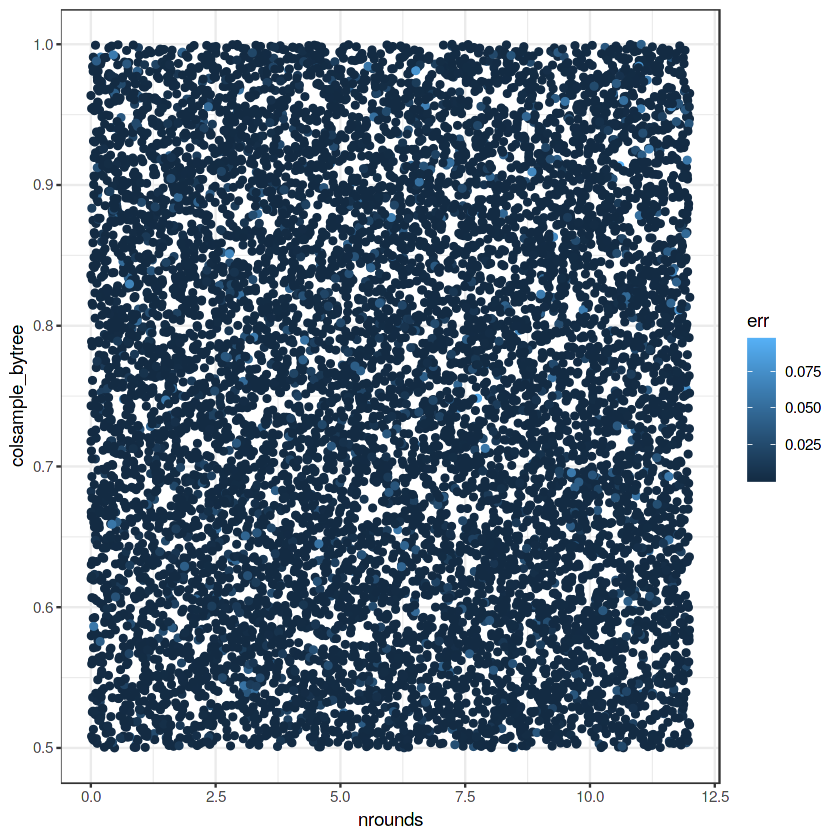

In [184]:
vars = hps[c(1, 5)]

p = ggplot(data = lhs_data, aes_string(x = vars[1], y = vars[2], colour = "err")) + geom_point()
# p = p + scale_fill_distiller(palette = "Spectral")
p 

We don't see anything. 

In [166]:
# Evaluate all models and train a randomForest on them
prob = "kc1"

paths_runs = file.path(path, prob, "mlrmbo_30_repls.rds")
path_lhs = file.path(path, prob, "random_lhs.rds")

lhs = readRDS(path_lhs)
lhs_data = lhs[1, ]$result[[1]]$opt.path
names(lhs_data)[ncol(opdf)] = "cb.lambda"

mbor = readRDS(paths_runs)

out = lapply(seq_len(nrow(mbor)), function(i) {

    opdf = mbor[i, ]$result[[1]]$opt.path
    models = mbor[i, ]$result[[1]]$models

    final_model = models[[length(models)]]

    names(opdf)[ncol(opdf)] = "cb.lambda"

    hps = names(opdf)[seq(which(names(opdf) == "y") - 1)]
    
    pred_gp_train = predict(final_model, newdata = opdf[, c(hps, "y")])
    perf_gp_train = performance(pred_gp_train, rmse)
   
    pred_gp = predict(model, newdata = lhs_data[, c(hps, "y")])
    perf_gp_lhs = performance(pred_gp, rmse)
    
    
    # Performance of a random forest
    lrn = makeLearner("regr.randomForest", predict.type = "se")
    task = mlr::makeRegrTask(id = "Fit RF surrogate", data = opdf[, c(hps, "y")], target = "y")

    model = train(lrn, task)
    
    pred_rf_train = predict(model, newdata = opdf[, c(hps, "y")])
    perf_rf_train = performance(pred_rf_train, rmse)
   
    pred_rf = predict(model, newdata = lhs_data[, c(hps, "y")])
    perf_rf_lhs = performance(pred_rf, rmse)
    
    return(data.frame(perf_gp_train = perf_gp_train, perf_gp_lhs = perf_gp_lhs, perf_rf_train = perf_rf_train, perf_rf_lhs = perf_rf_lhs))
})

out = do.call(rbind, out)

In [168]:
bla = reshape2::melt(data = out)

No id variables; using all as measure variables



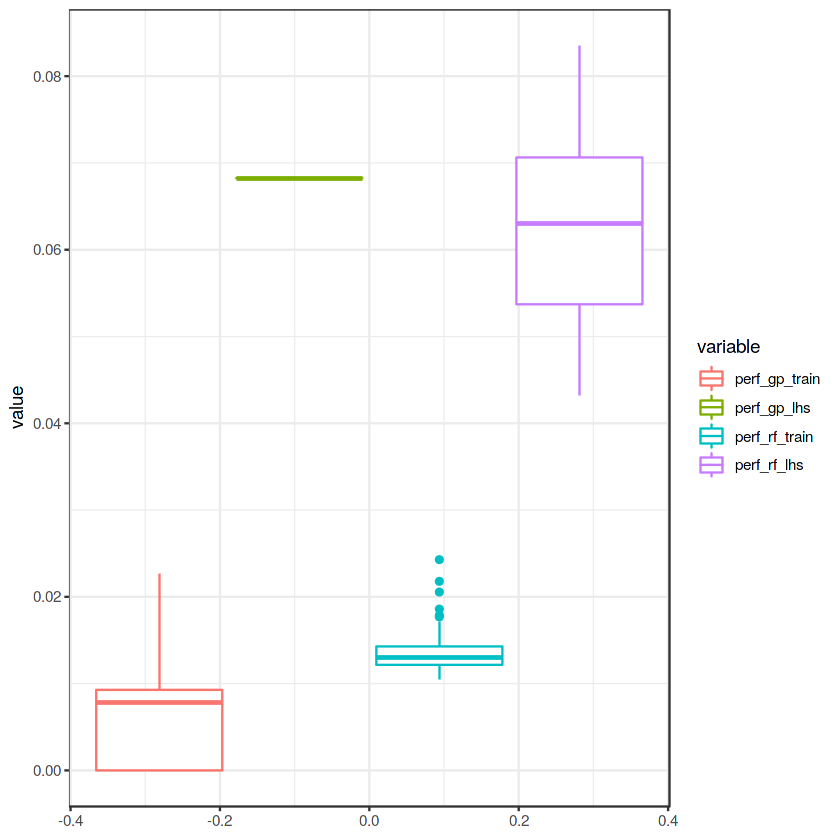

In [174]:
ggplot(data = bla, aes(y = value, group = variable, colour = variable)) + geom_boxplot() 

## Synthetic Test Data 

Problem: When we use a randomLHS for testing, we are testing on out of distribution data. Ideally, we would like to test in data that corresponds to a distribution that coincides with the distribution of the training data. 

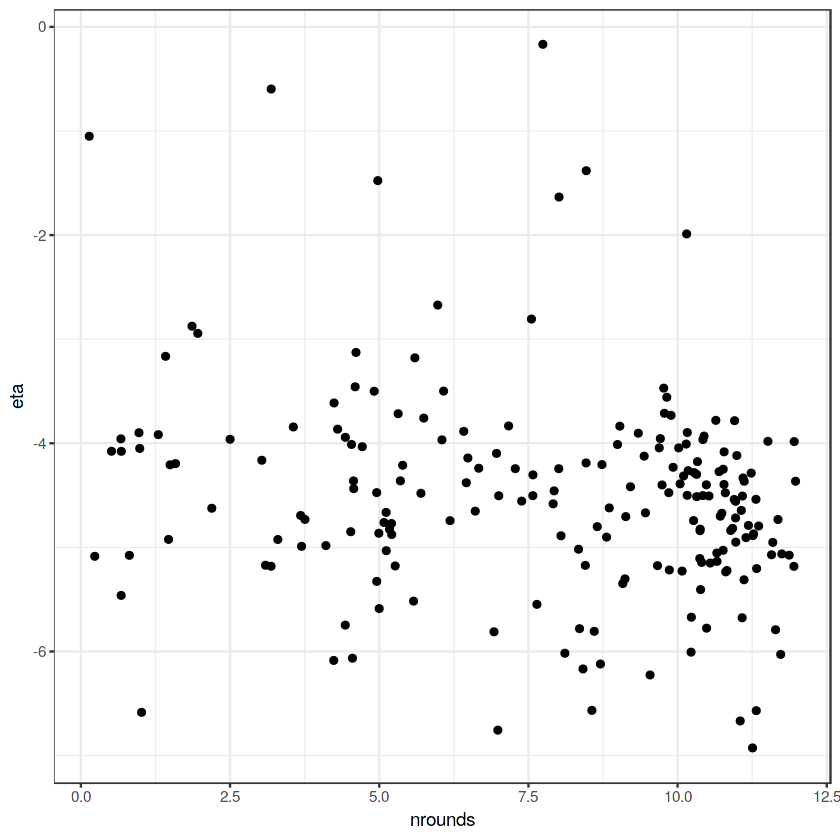

In [26]:
p = ggplot(data = opdf, aes_string(x = hps[1], y = hps[2])) + geom_point()
p

In [27]:
res = lapply(1:3, function(comp) {
    tryCatch({
        mvnormalmixEM(opdf[, 1:9], k = comp, epsilon = 1e-02)
    }, error = function(e) NA)
})
res

number of iterations= 16 


[[1]]
[1] NA

[[2]]
$x
          nrounds        eta       gamma max_depth colsample_bytree
  [1,]  4.6103278 -3.1275180 -2.97162177        18        0.6278512
  [2,] 10.1521912 -1.9890003  1.22122550        17        0.8694173
  [3,]  3.1892837 -0.5971638  5.89371626        12        0.5792848
  [4,]  0.1398728 -1.0508551  2.47879945        20        0.8333588
  [5,]  6.9235083 -5.8110093  3.40906857         8        0.9529406
  [6,]  8.8093849 -4.9013517  1.70682018        11        0.9815941
  [7,] 11.0490664 -6.6672192 -6.61475484        14        0.5842909
  [8,]  6.0505327 -3.9670803 -5.85956456        13        0.5058599
  [9,]  1.0172112 -6.5847883 -1.83723892         7        0.7483911
 [10,]  3.5606452 -3.8433181 -5.30743619         6        0.8113911
 [11,]  8.0126943 -1.6347838  4.24596353        10        0.7692351
 [12,]  4.9757519 -1.4770056 -2.56508222        19        0.9305156
 [13,]  9.8615831 -5.2171819  0.00620966        16        0.7127396
 [14,] 11.7278421 -6.0282

In [34]:
data(wdbc, package = "kdecopula")                     # load datau <- VineCopula::pobs(wdbc[, 5:7], ties = "average")  # rank-transform# estimate densityfit <- kdevinecop(u)# contour matrixcontour(fit)

ERROR: Error in find.package(package, lib.loc, verbose = verbose): there is no package called ‘kdecopula’


In [28]:
# get the randomLHS
ps = makeParamSet(
        # do early stopping instead for the bigger datasets
        makeNumericParam("nrounds", lower = 0, upper = 12, trafo = function(x) round(2^x)), # 2^13 = 8192	
        makeNumericParam("eta", lower = -7, upper = 0, trafo = function(x) 2^x), # 2^(-7) = 0.007 < 0.01
        makeNumericParam("gamma", lower = -7, upper = 6, trafo = function(x) 2^x), 
        makeIntegerParam("max_depth", lower = 3, upper = 20),
        makeNumericParam("colsample_bytree", lower = 0.5, upper = 1),
        makeNumericParam("colsample_bylevel", lower = 0.5, upper = 1),
        makeNumericParam("lambda", lower = -10, upper = 10, trafo = function(x) 2^x),
        makeNumericParam("alpha", lower = -10, upper = 10, trafo = function(x) 2^x),
        makeNumericParam("subsample", lower = 0.5, upper = 1)
    )

des = generateGridDesign(par.set = ps, resolution = 3, trafo = TRUE)

In [29]:
des

nrounds,eta,gamma,max_depth,colsample_bytree,colsample_bylevel,lambda,alpha,subsample
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00781250,0.0078125,3,0.5,0.5,0.0009765625,0.0009765625,0.5
64,0.00781250,0.0078125,3,0.5,0.5,0.0009765625,0.0009765625,0.5
4096,0.00781250,0.0078125,3,0.5,0.5,0.0009765625,0.0009765625,0.5
1,0.08838835,0.0078125,3,0.5,0.5,0.0009765625,0.0009765625,0.5
64,0.08838835,0.0078125,3,0.5,0.5,0.0009765625,0.0009765625,0.5
4096,0.08838835,0.0078125,3,0.5,0.5,0.0009765625,0.0009765625,0.5
1,1.00000000,0.0078125,3,0.5,0.5,0.0009765625,0.0009765625,0.5
64,1.00000000,0.0078125,3,0.5,0.5,0.0009765625,0.0009765625,0.5
4096,1.00000000,0.0078125,3,0.5,0.5,0.0009765625,0.0009765625,0.5


In [30]:
mixx = res[[2]]

In [31]:
dens_comp = lapply(seq_along(mixx$mu), function(comp) {
    apply(as.matrix(des), 1, function(y) dmvnorm(y = y, mu = mixx$mu[[comp]], sigma = mixx$sigma[[comp]]))
})
    
dens_comp = do.call("cbind", dens_comp)

In [32]:
des$z = dens_comp %*% mixx$lambda
des = as.data.frame(des)

Warning message:
“stat_contour(): Zero contours were generated”
Warning message in min(x):
“no non-missing arguments to min; returning Inf”
Warning message in max(x):
“no non-missing arguments to max; returning -Inf”


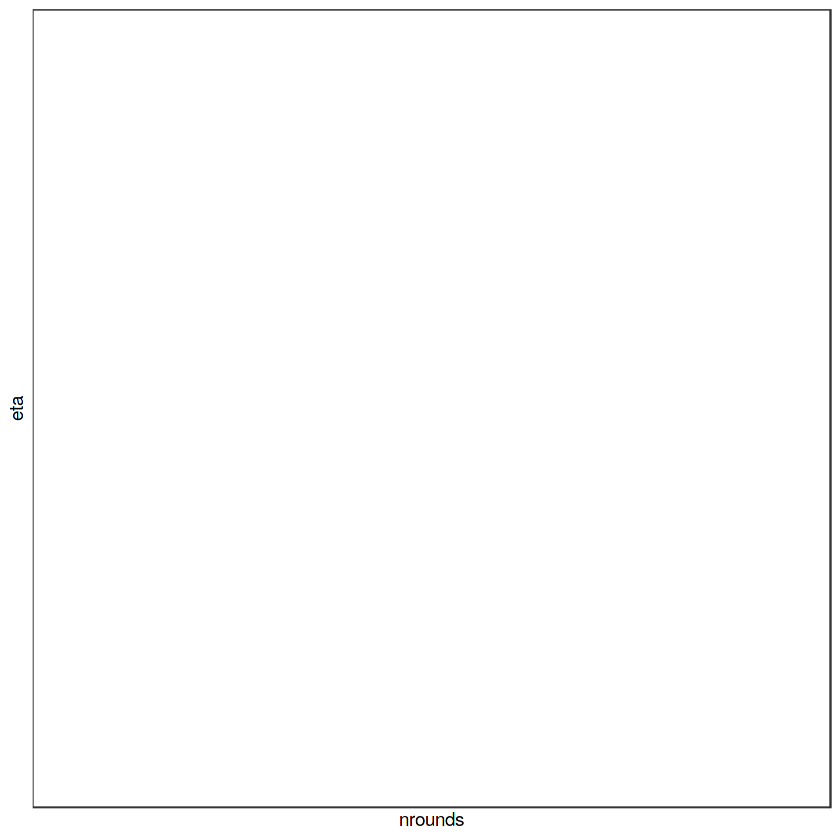

In [33]:
p = ggplot(data = opdf, aes(x = nrounds, y = eta)) + geom_point()
p = ggplot(data = des, aes(x = nrounds, y = eta, z = z)) + stat_contour()
p

In [71]:
des

,nrounds,eta,gamma,max_depth,colsample_bytree,colsample_bylevel,lambda,alpha,subsample,z
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>"
1,0.8742274,-2.3299799,3.47680305,6,0.8361190,0.5369937,-9.9487908,-0.05733489,0.9528897,1.539937e-10
2,9.2079106,-5.6709308,1.93438731,17,0.6654096,0.6048102,9.9546443,-5.29474007,0.9067115,2.276637e-12
3,7.7709177,-6.1372078,-4.89376248,17,0.5519932,0.7412995,-3.6980096,6.52094795,0.6757006,5.379375e-07
4,11.4729729,-1.5857902,2.86034433,12,0.6241603,0.6482539,-9.2983235,-7.96005451,0.9264151,7.961542e-12
5,11.1955124,-2.9608211,-0.46010694,8,0.6363770,0.8947323,-3.9124736,-1.21855551,0.8943593,1.781907e-08
6,5.4674582,-3.9317571,4.87861675,13,0.5737455,0.5911710,-6.4578016,-3.37836764,0.8989987,1.826286e-09
7,1.3459473,-6.6129496,-2.08081893,7,0.9102973,0.8039766,5.6727207,0.39458348,0.8850269,1.952233e-08
8,4.8026376,-3.0220046,4.26437054,7,0.5824330,0.7293738,-3.5281035,5.80073921,0.5554220,3.889321e-10
9,9.0238439,-2.1984610,-1.13125637,4,0.5558287,0.8785783,-0.4768019,5.72588701,0.7867202,6.601106e-09


Warning message in min(x, na.rm = na.rm):
“no non-missing arguments to min; returning Inf”
Warning message in max(x, na.rm = na.rm):
“no non-missing arguments to max; returning -Inf”
ERROR while rich displaying an object: Error: stat_contour requires the following missing aesthetics: y and z

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[

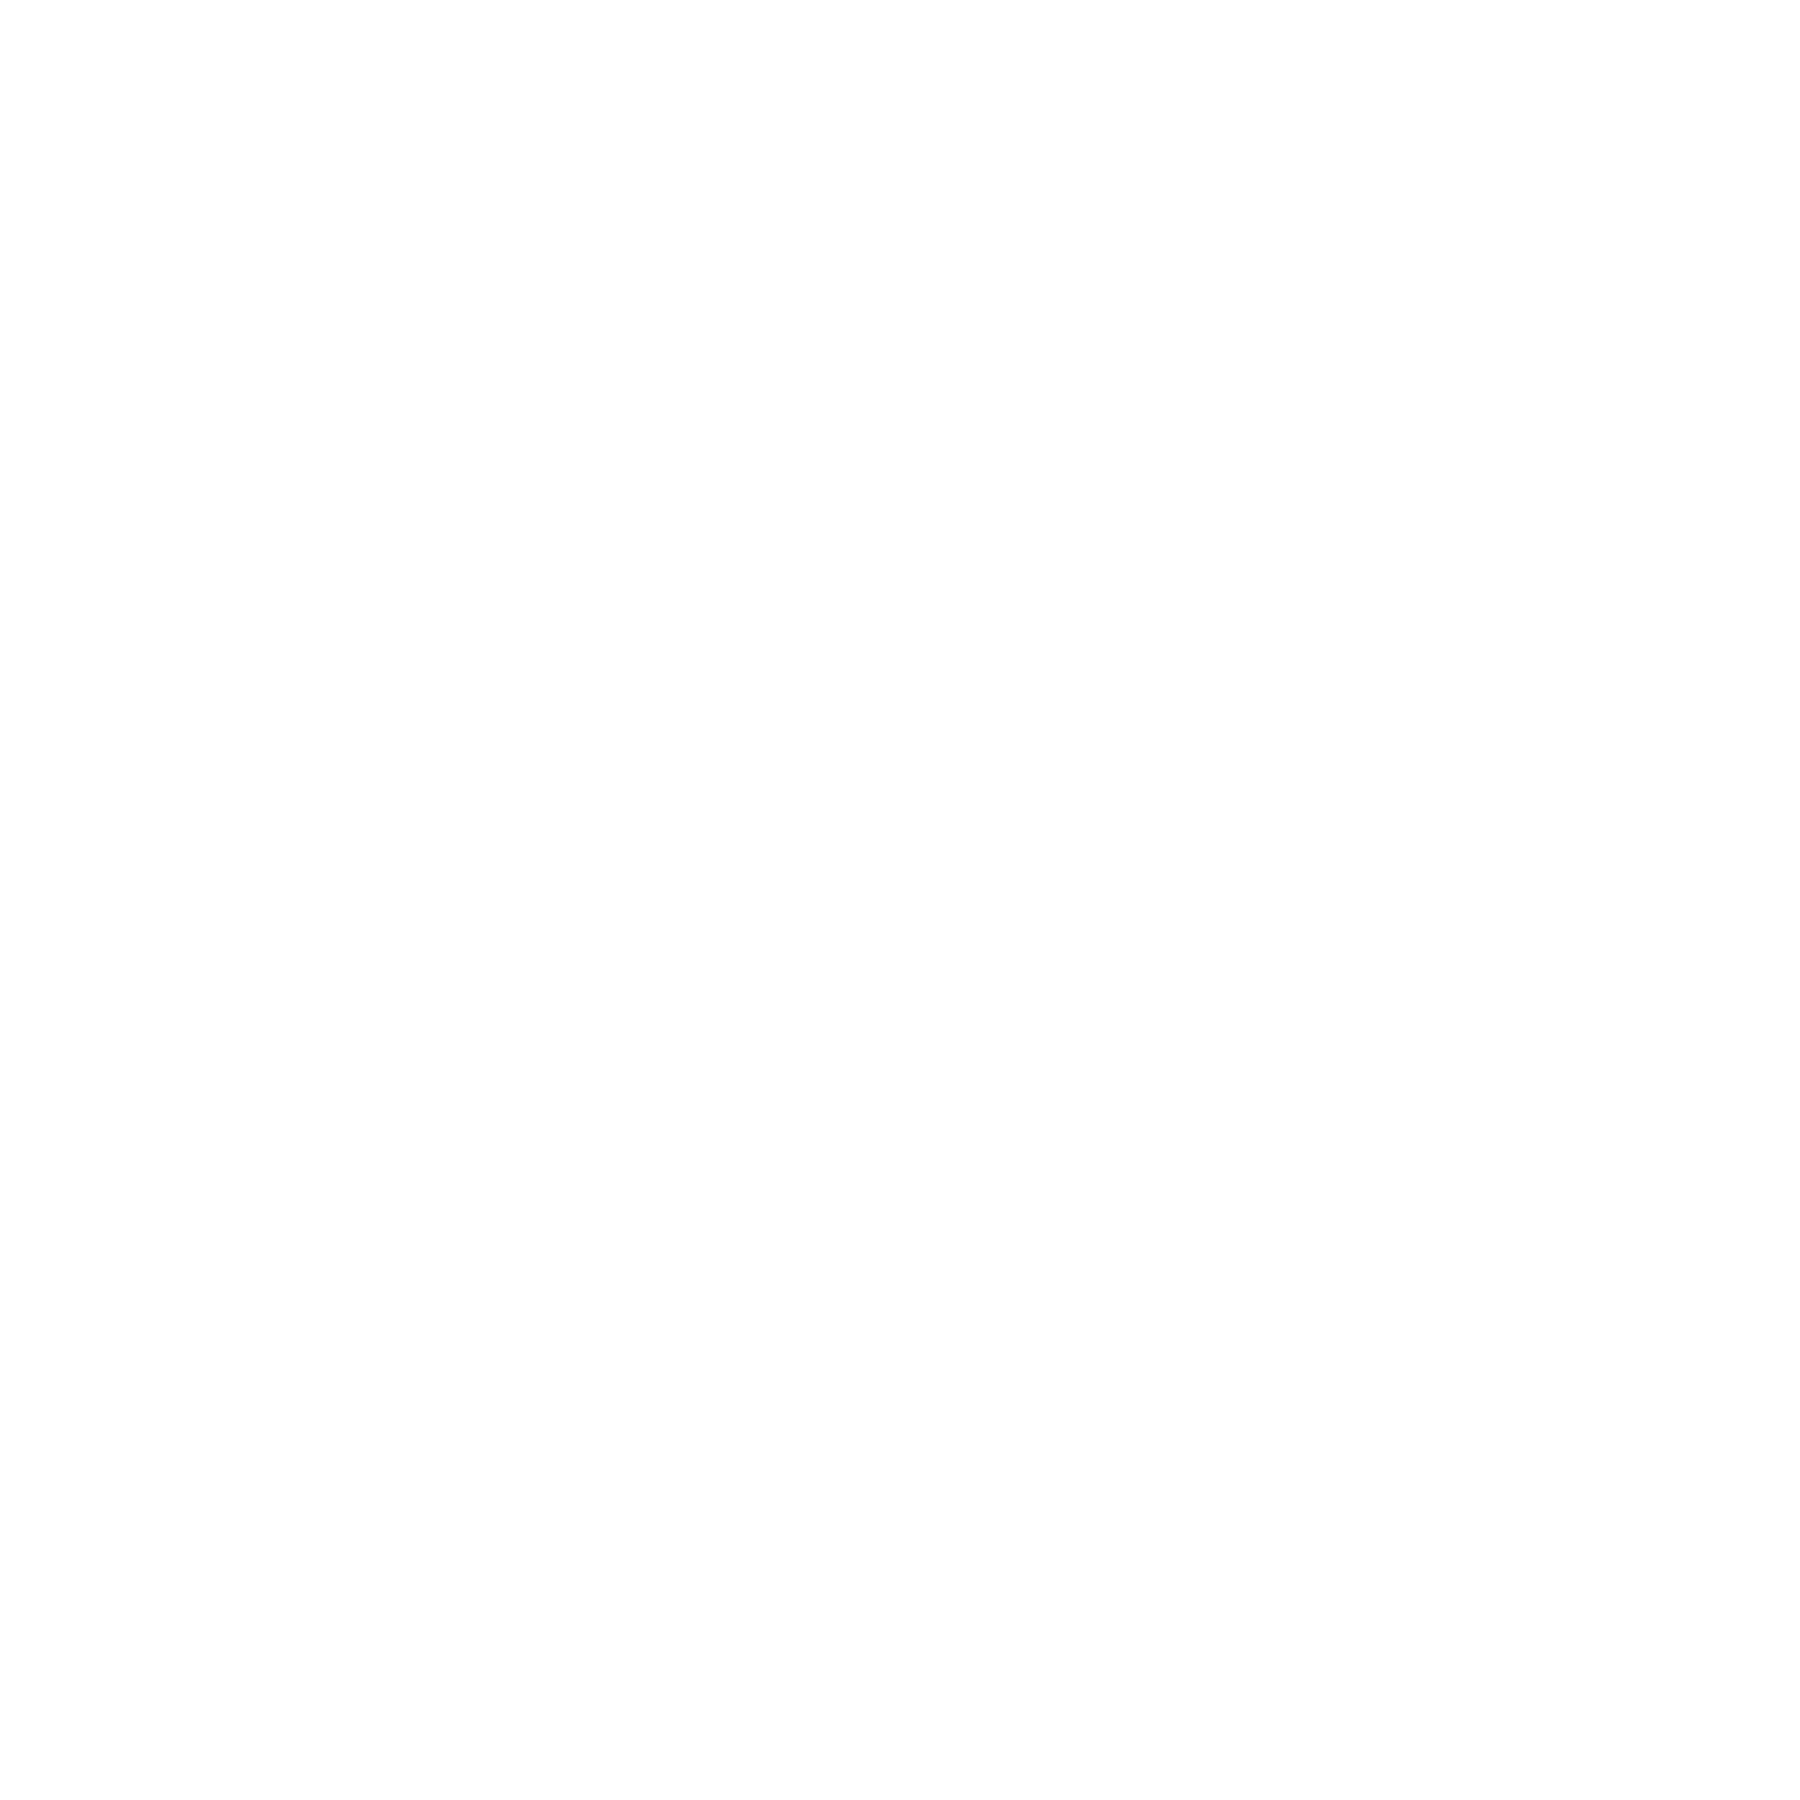

In [66]:
options(repr.plot.width=15, repr.plot.height=15)

ggpairs(opdf[, 1:9]) + geom_contour(data = opdf[, 1:9])

## Visualize Performance of the Models

In [ ]:
# Evaluate performance on the trainings set



In [ ]:
# Evaluate performance on the test set (out-of-distribution)

In [ ]:
# Evaluate performance on the test set (in-distribution)

## Visualize Runtime of both a RandomForest and a Gaussian Process

Why is runtime important? 

* Makes our experiments faster (not super important, because we usually assume that ML experiments are the expensive parts)
* Allows us to fit a "perfect" model on the randomLHS (that is fitted on unbiased data), to compare predictions that come from an unbiased workflow vs. a biased one


In [ ]:
ps_surrogate = makeParamSet(
        makeNumericParam("num.trees", lower = log(10, 2), upper = log(500, 2), trafo = function(x) round(2^x)), # 2^13 = 8192	
        makeLogicalParam("do.mtry"),
        makeIntegerParam("min.node.size", lower = 1L, upper = 5L),
        makeIntegerParam("num.random.splits", lower = 1, upper = 100)
    )

In [ ]:
lrn_10 = makeLearner("regr.ranger")
lrn_500 = makeLearner("regr.ranger")